In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from ikflow.model_loading import get_ik_solver
from ikflow.ikflow_solver import draw_latent
from ikflow.config import DEVICE
import torch
import numpy as np
from time import time, sleep
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.curdir, '..')))
from src.utils import RepoDir, BuildEnv, DrawAxes
import numpy as np
from pydrake.all import (
    StartMeshcat, 
    RigidTransform,
    Quaternion,
)


model_name = "panda__full__lp191_5.25m"

ik_solver, hyper_parameters = get_ik_solver(model_name)
robot = ik_solver.robot


meshcat = StartMeshcat()
diagram = BuildEnv(meshcat=meshcat, directives_file = os.path.join(RepoDir(), "models/panda/panda_collision.yaml"))
plant = diagram.GetSubsystemByName("plant")
diagram_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(diagram_context)
diagram.ForcedPublish(diagram_context)

ikflow/config.py | Using device: 'cuda:0'
WorldModel::LoadRobot: /home/tangles/.cache/jrl/urdfs/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
Geometry: Loading 12 meshes from /home/tangles/Urop/ikflow/.venv/lib/python3.10/site-packages/jrl/urdfs/panda/meshes/visual/link0.dae into Group
Geometry: Loading 4 meshes from /home/tangles/Urop/ikflow/.venv/lib/python3.10/site-packages/jrl/urdfs/panda/meshes/visual/link3.dae into Group
Geometry: Loading 4 meshes from /home/tangles/Urop/ikflow/.venv/lib/python3.10/site-packages/jrl/urdfs/panda/meshes/visual/link4.dae into Group
Geometry: Loading 3 meshes from /home/tangles/Urop/ikflow/.venv/lib/python3.10/site-packages/jrl/urdfs/panda/meshes/visual/link5.dae into Group
Geometry: Loading 17 meshes from /home/tangles/Urop/ikflow/.venv/lib/python3.10/site-packages/jrl/urdfs/panda/meshes

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
latent = torch.tensor(np.random.randn(1,ik_solver.network_width), device=DEVICE, dtype=torch.float32) 
T = RigidTransform(np.array([[0, 0, 1, -0.1],[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1]]))

def get_ik_solution(target_pose, latent = None):
    '''
    Computes IK solution using IKFlow, and visualizes target pose in MeshCat in Drake
        Target Pose is numpy array of shape (7,) in the format [x y z qw qx qy qz]'''
    target_pose = torch.tensor(
        target_pose, device=DEVICE
    )
    conditional = torch.cat([target_pose.expand((1, ik_solver.network_width)), torch.zeros((1, 1), dtype=torch.float32, device=DEVICE)], dim=1)
    sol = ik_solver.nn_model(latent, c=conditional, rev=True)
    q = np.zeros(plant.num_positions())
    q[:7] = sol[0].detach().cpu().numpy()
    plant.SetPositions(plant_context, q)
    diagram.ForcedPublish(diagram_context)

    pose = target_pose.detach().cpu().numpy()
    pose = RigidTransform(Quaternion(pose[3], pose[4], pose[5], pose[6]), [pose[0], pose[1], pose[2]])
    T_gripper = pose.multiply(T.inverse())

    DrawAxes(T_gripper, meshcat)
    return q

In [4]:
### QUESTION: Is the model roughly continuous in physical space with the same latent vector?
latent = torch.tensor(np.random.randn(1,ik_solver.network_width), device=DEVICE, dtype=torch.float32) 
start = np.array([0.5, 0.5, 0.5, 1, 0, 0, 0], dtype=np.float32)
end = np.array([-0.5, 0.5, 0.5, -0.6, 0.48, 0.64, 0], dtype=np.float32)

# Linear interpolation for position (first 3)
# SLERP for quaternion (last 4)
t = np.linspace(0, 1, 1000, dtype=np.float32)

pos_start, quat_start = start[:3], start[3:]
pos_end, quat_end = end[:3], -end[3:]

positions = np.outer(1-t, pos_start) + np.outer(t, pos_end)

angle = np.arccos(np.clip(np.dot(quat_start, quat_end), -1, 1))
quats = np.array([
    (np.sin((1-ti)*angle) * quat_start + np.sin(ti*angle) * quat_end) / np.sin(angle)
    for ti in t
])

samples = np.hstack([positions, quats])


for sample in samples:
    get_ik_solution(target_pose=sample, latent=latent)
    sleep(0.01)

In [5]:
get_ik_solution(target_pose = start, latent=latent)
frame = plant.GetBodyByName("panda_link8").body_frame()

pose = frame.CalcPoseInWorld(plant_context)
print(pose.translation())
print(pose.rotation().ToQuaternion().wxyz())


print(plant.GetPositionLowerLimits())
print(plant.GetPositionUpperLimits())



[0.49960785 0.4992038  0.49958211]
[ 0.92281652 -0.00531367 -0.00263964  0.38519407]
[-2.8973 -1.7628 -2.8973 -3.0718 -2.8973 -0.0175 -2.8973  0.      0.    ]
[ 2.8973  1.7628  2.8973 -0.0698  2.8973  3.7525  2.8973  0.04    0.04  ]


In [16]:
### QUESTION 2: Is the model roughly continuous in latent space for the same target pose?
target_pose = np.array([0.5, 0.5, 0.5, 1, 0, 0, 0], dtype=np.float32)

def hit_and_run_ball_small_steps(n_samples, dim=7, radius=1.5, step_size=0.1, x0=None):
    if x0 is None:
        x0 = np.zeros(dim, dtype=np.float32)
    
    samples = [x0]
    x = x0.copy()
    
    while len(samples) < n_samples:
        # Random direction
        direction = np.random.randn(dim).astype(np.float32)
        direction /= np.linalg.norm(direction)
        
        # Find max step along direction
        a = np.float32(1.0)
        b = np.float32(2.0) * np.dot(x, direction)
        c = np.dot(x, x) - np.float32(radius**2)
        discriminant = b**2 - np.float32(4.0)*a*c
        t_max = (-b + np.sqrt(discriminant)) / (np.float32(2.0)*a)
        t_min = (-b - np.sqrt(discriminant)) / (np.float32(2.0)*a)
        
        # Sample point on line
        t_end = np.float32(np.random.uniform(t_min, t_max))
        
        # Take small steps along line
        n_steps = int(abs(t_end) / step_size) + 1
        for t in np.linspace(0, t_end, n_steps, dtype=np.float32):
            x_new = x + t * direction
            samples.append(x_new.copy())
            if len(samples) >= n_samples:
                break
        
        x = samples[-1]
    
    return np.array(samples[:n_samples], dtype=np.float32)

# Usage
samples = hit_and_run_ball_small_steps(1000, dim=7, step_size=0.005)


In [19]:
errors = []
for sample in samples:
    get_ik_solution(target_pose=target_pose, latent=torch.tensor(sample.reshape(1,7), device=DEVICE, dtype=torch.float32))
    real_pose = frame.CalcPoseInWorld(plant_context)

    errors.append(np.linalg.norm(real_pose.translation() - target_pose[:3]))
    
    sleep(0.01)



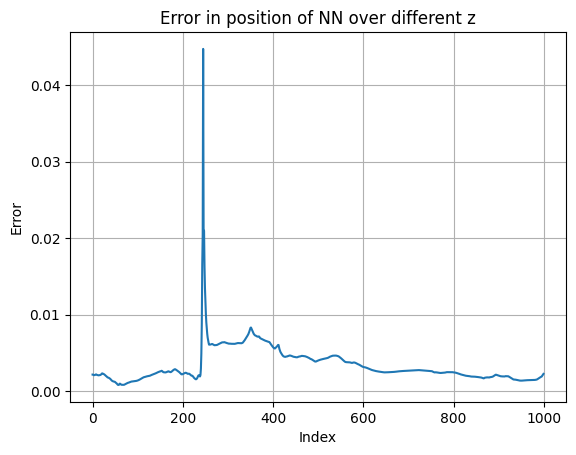

In [ ]:
import matplotlib.pyplot as plt

plt.plot(errors)
plt.xlabel('Index')
plt.ylabel('Error')
plt.title('Error in position of NN over different z in random walk')
plt.grid(True)
plt.show()
